<h1>Research Question</h1>
Can we reliably predict a county's electric vehicle (EV) registrations based of of vehicles' model year, manufacturer brand, electric range, and other factors in Washington State?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

import statsmodels.api as sm  # Optional for detailed statistical analysis


## Data Description
We are using a dataset that shows the Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department of Licensing (DOL). It provides key information about vehicle registrations, tax exemptions, and eligibility criteria for clean alternative fuel vehicles, and is updated regularly, with the monthly vehicle count subject to changes due to county assignment processes during registration. A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source. A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source.

The dataset consists of several columns representing various attributes related to each electric vehicle, including: VIN: Vehicle Identification Number; County: The county where the vehicle is registered; City: The city where the vehicle is registered; State: The state (WA for Washington); Postal Code: The postal code of the registration; Model Year: The year the vehicle model was manufactured; Make: The manufacturer brand of the vehicle; Model: The model of the vehicle. Each row in the dataset describes a specific electric vehicle that is registered in Washington State.

## Data Cleaning

In [2]:
df = pd.read_csv('Combined_Data.csv', encoding='ISO-8859-1')
print(df.shape)
df.head()

(77114, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,income_2023,population_2023
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),119926.0,6794340.0
1,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),119926.0,6794340.0
2,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),119926.0,6794340.0
3,3FA6P0SU8H,Thurston,Yelm,WA,98597.0,2017,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,0,2.0,122057736,PUGET SOUND ENERGY INC,91522.0,766220.0
4,1N4AZ0CP2D,Yakima,Yakima,WA,98903.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,14.0,150126840,PACIFICORP,65167.0,694445.0


In [3]:
aggregated_df = duckdb.sql("""
    SELECT 
        County,
        COUNT(*) AS "Total EV Count",  -- Total count of all EVs in the county
        AVG("Electric Range") AS "Average Electric Range", -- Average Electric Range in the county
        AVG("Model Year") AS "Average Model Year", -- Average EV Model Year in the county
        MODE("Make") AS "Popular Brand", -- Most popular EV Brand in the county
        MODE("Model") AS "Popular Model", -- Most popular EV model in the county
        MODE("Electric Vehicle Type") AS "Popular EV Type", -- Most popular EV type in the county (BEV or PHEV)
        SUM(CASE WHEN "Electric Vehicle Type" = 'Battery Electric Vehicle (BEV)' THEN 1 ELSE 0 END) AS "BEV Count",  -- Count of BEVs
        SUM(CASE WHEN "Electric Vehicle Type" = 'Plug-in Hybrid Electric Vehicle (PHEV)' THEN 1 ELSE 0 END) AS "PHEV Count",  -- Count of PHEVs
        AVG("income_2023") AS "Average Income",  -- Average income in the county
        AVG("population_2023") AS "Population",  -- Population in the county
        -- Calculating BEV proportion directly within the query
        SUM(CASE WHEN "Electric Vehicle Type" = 'Battery Electric Vehicle (BEV)' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS "BEV Proportion"  -- Proportion of BEVs
    FROM df
    GROUP BY County
    ORDER BY County ASC
""").df()
aggregated_df.head()

,County,Total EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,BEV Count,PHEV Count,Average Income,Population,BEV Proportion
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),10.0,9.0,64498.0,54015.0,0.526316
1,Alameda,2,131.000000,2020.000000,TESLA,MODEL 3,Battery Electric Vehicle (BEV),1.0,1.0,NaN,NaN,0.500000
2,Albemarle,2,211.500000,2016.000000,TESLA,MODEL 3,Battery Electric Vehicle (BEV),2.0,0.0,NaN,NaN,1.000000
3,Alexandria,2,326.000000,2020.000000,TESLA,MODEL S,Battery Electric Vehicle (BEV),2.0,0.0,NaN,NaN,1.000000
4,Allen,2,121.500000,2017.500000,CHRYSLER,PACIFICA,Plug-in Hybrid Electric Vehicle (PHEV),1.0,1.0,NaN,NaN,0.500000


## Pre Registration Statements
### Statement 1
**Hypothesis:** Counties with a higher density of BEVs (Battery Electric Vehicles) relative to other types of EVs have higher total EV registrations.

**Analysis:** We will calculate the proportion of BEVs among all EVs for each county. Then, we will perform a linear regression with the BEV proportion (for each county) as the input variable and the total EV registrations (for each county) as the output. The goal is to test whether the coefficient for BEV proportion indicates a meaningful link between BEV density and overall EV registrations within each county. We chose linear regression because it can detect direct correlations between BEV popularity and overall adoption trends. We will test whether BEV > 0. If it is significantly positive, then it indicates that the counties with higher BEV proportion tend to have more total EV registrations. Additionally, if a relationship exists, it could inform further investigation into socioeconomic or geographic factors that may affect EV adoption rates.

In [4]:
# Remove rows where BEV Proportion or Total EV Count is zero or null (to avoid issues in regression)
ev_density_by_county = aggregated_df.dropna(subset=["BEV Proportion", "Total EV Count"])
ev_density_by_county = aggregated_df[aggregated_df["Total EV Count"] > 0]

# Define independent variable (BEV Proportion) and dependent variable (Total EV Count)
X = ev_density_by_county["BEV Proportion"]
y = ev_density_by_county["Total EV Count"]

# Add a constant to the independent variable for the intercept term in the regression model
X = sm.add_constant(X)

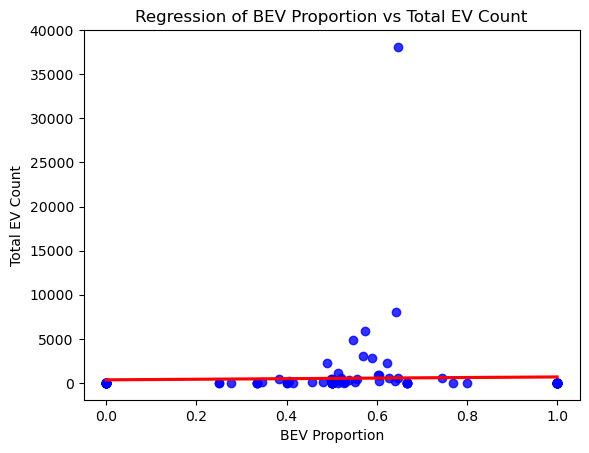

In [5]:
sns.regplot(x="BEV Proportion", y="Total EV Count", data=ev_density_by_county, 
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, 
            ci=None)  
plt.xlabel("BEV Proportion")
plt.ylabel("Total EV Count")
plt.title("Regression of BEV Proportion vs Total EV Count")

plt.show()

#### Null and Alternative Hypotheses
Null Hypothesis ($H_0$): The coefficient of BEV Proportion is equal to 0.
This implies that there is no significant relationship between the proportion of Battery Electric Vehicles (BEVs) in a county and the total number of EV registrations.

Alternative Hypothesis ($H_A$): The coefficient of BEV Proportion is not equal to 0.
This implies that there is a significant relationship between the proportion of BEVs in a county and the total number of EV registrations.




In [6]:
# Perform the linear regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Total EV Count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2311
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.631
Time:                        13:27:22   Log-Likelihood:                -1407.0
No. Observations:                 148   AIC:                             2818.
Df Residuals:                     146   BIC:                             2824.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            351.3509    443.989      0.

### Interpretation

There is no statistically significant relationship between the proportion of BEVs (Battery Electric Vehicles) in a county and the total EV registrations. According to the regression, for every 1-unit increase in BEV proportion (e.g., moving from 50% BEVs to 100% BEVs), the total number of EV registrations increases by approximately 329 vehicles.

### Predictions
When BEV Proportion = 0, 
Total EV Count = 351.35 + 329 $\cdot$ (BEV Proportion) = 351.35 + 329.38 $\cdot$ 0 = 351.35
This suggests that a country with no BEVs would still have 351 EV registrations. 

When BEV Proportion = 1, 
Total EV Count = 351.35 + 329 $\cdot$ (BEV Proportion) = 351.35 + 329.38 $\cdot$ 1 = 680.73
This suggests that a county where all registered EVs are BEVs is expected to have about 681 total EV registrations.


### Potential Oddities
The coefficient for BEV Proportion is not statistically significant ($p = 0.631$), meaning the relationship may not be reliable.  
The model may predict fractional EV registrations (e.g., 0.5 or 2.3 EVs), which is not realistic since EV registrations must be whole numbers.  
Counties with very high BEV proportions (e.g., 100%) might still have relatively few total EV registrations due to small population sizes, making the relationship appear artificially strong or weak depending on the scale of the data.  
The model does not account for counties with zero EV registrations, even if they have a non-zero BEV proportion.  
The relationship assumes linearity with may oversimplify real-world trends in EV adoption.

### Statistical Significance

P-value: 0.631: The intercept is not statistically significant because it is much greater than the common significance threshold (0.05), meaning we cannot reject the null hypothesis. There is no strong evidence to suggest that the BEV Proportion is significantly associated with Total EV Count.

The R-squared is 0.002, meaning that only 0.2% of the variation in Total EV Count is explained by the BEV Proportion. This indicates a very poor model fit, suggesting that BEV Proportion alone is not a good predictor of Total EV Count

The 95% confidence interval for the BEV Proportion coefficient is [-1024.716, 1683.471]. This wide interval indicates high uncertainty about the true effect of BEV proportion, and the interval includes 0, further supporting the lack of statistical significance.

The high p-value, low R-squared value, and wide confidence interval suggest no statistically significant relationship between BEV Proportion and total EV registrations. The model does not provide strong evidence to support the hypothesis.

We fail to reject the null hypothesis, meaning there is no evidence that the proportion of BEVs is significantly associated with higher total EV registrations. This indicates that BEV density alone is not a reliable predictor of EV registrations in counties.

## Pre Registration Statements
### Statement 2
**Hypothesis:** Counties with higher median incomes are correlated with a greater number of registered electric vehicles.

**Analysis:** We will combine EV registration by county and the median income by county from the median income dataset. Where each row represents a different county, we run a linear regression for median income in 2023 as input and the number of registered electric vehicles as output. Because the coefficient can contain signs to indicate a positive or negative relationship between the two variables, we will test whether income  0. If it is significantly positive, then it indicates that high-income countries tend to have more EVs. We will also evaluate the R-squared value to understand how much of the variation in EV registrations is explained by median income and other factors included in the model.

In [7]:
# Filter for non-null data
filtered_df = aggregated_df.dropna(subset=["Average Income", "Population"]).copy()
filtered_df["EVs per 1000"] = (filtered_df["Total EV Count"] / filtered_df["Population"]) * 1000
filtered_df.head()

,County,Total EV Count,Average Electric Range,Average Model Year,Popular Brand,Popular Model,Popular EV Type,BEV Count,PHEV Count,Average Income,Population,BEV Proportion,EVs per 1000
0,Adams,19,131.842105,2018.105263,TESLA,MODEL 3,Battery Electric Vehicle (BEV),10.0,9.0,64498.0,54015.0,0.526316,0.351754
7,Asotin,41,89.414634,2018.975610,TOYOTA,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),17.0,24.0,67820.0,53745.0,0.414634,0.762862
10,Benton,1120,125.328571,2018.716964,TESLA,MODEL 3,Battery Electric Vehicle (BEV),576.0,544.0,87992.0,608885.0,0.514286,1.839428
21,Chelan,510,142.231373,2018.533333,TESLA,LEAF,Battery Electric Vehicle (BEV),330.0,180.0,84430.0,210625.0,0.647059,2.421365
23,Clallam,573,110.722513,2018.186736,CHEVROLET,LEAF,Battery Electric Vehicle (BEV),299.0,274.0,68924.0,188135.0,0.521815,3.045685


Text(0.5, 1.0, 'Average Income vs. Total EV Count for Counties')

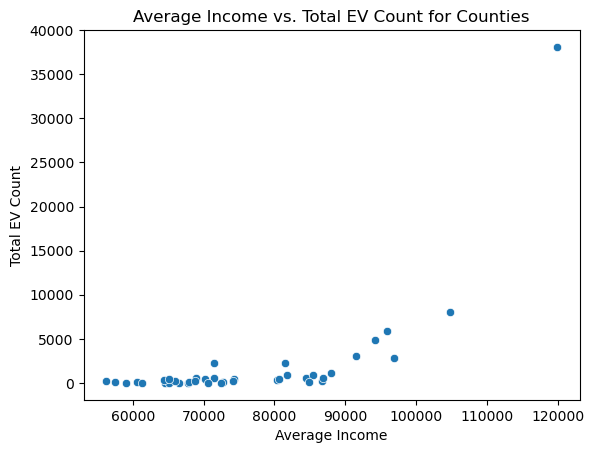

In [8]:
sns.scatterplot(x='Average Income', y = 'Total EV Count', data = filtered_df)
plt.title('Average Income vs. Total EV Count for Counties')

In [9]:
# Linear regression
X = filtered_df["Average Income"].values.reshape(-1,1)
y = filtered_df["Total EV Count"].values

model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")

print(f"Coefficient for Median Income: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

R-squared: 0.45
Coefficient for Median Income: 0.30
Intercept: -20691.03


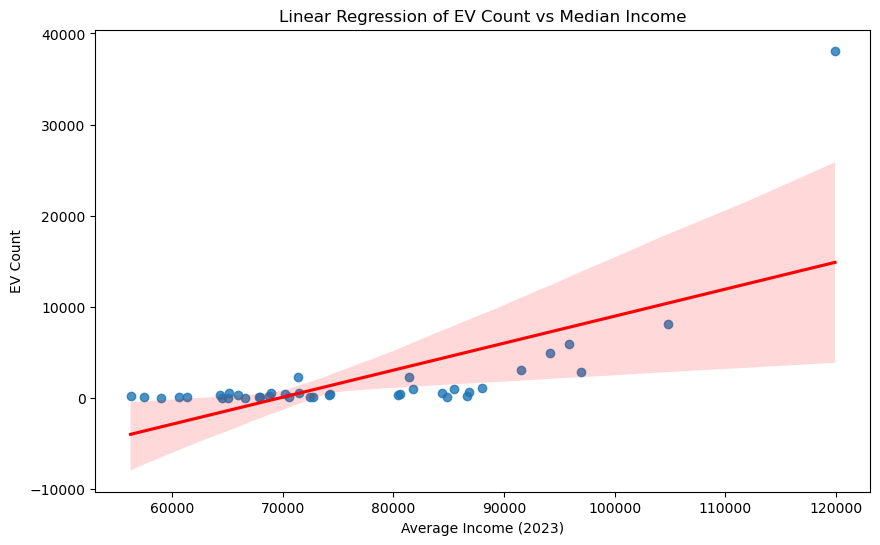

In [10]:
# Plot the regression
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_df["Average Income"], y=filtered_df["Total EV Count"], line_kws={"color": "red"})
plt.title("Linear Regression of EV Count vs Median Income")
plt.xlabel("Average Income (2023)")
plt.ylabel("EV Count")
plt.show()

#### Null and Alternative Hypotheses
Null Hypothesis ($H_0$): The coefficient of Average Income is equal to 0.
This implies that there is no significant relationship between the median income of a county and the number of registered EVs.

Alternative Hypothesis ($H_A$): The coefficient of Average Income is not equal to 0.
This implies that there is a significant relationship between the median income of a county and the number of registered EVs.


In [11]:
X_with_const = sm.add_constant(X)  
ols_model = sm.OLS(y, X_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     29.94
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           3.26e-06
Time:                        13:27:23   Log-Likelihood:                -383.80
No. Observations:                  39   AIC:                             771.6
Df Residuals:                      37   BIC:                             774.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.069e+04   4208.483     -4.917      0.0

### Interpretation

There is a statistically significant positive relationship between average income in a county and the total number of EVs registered. According to the regression, for every $1 increase in average income, the total EV count increases by approximately 0.3 vehicles.  

### Predictions
When average income = 0,   
Total EV Count = -20,681.03 + 0.3 $\cdot$ (Average Income) = -20,681.03 + 0.30 $\cdot$ 0 = -20,681.03
This is unrealistic since income and EV registrations cannot be negative, suggesting limitations in the model for low-income counties.

When average income = 100,000,     
Total EV Count =  -20,681.03 + 0.3 $\cdot$ (Average Income) = -20,681.03 + 0.30 $\cdot$ 100,000 = 9,308.97
This prediction suggests that counties with higher incomes (e.g., $100,000 average) could see significant EV registrations.

### Potential Oddities
The model predicts negative EV registrations for counties with very low average income, which is nonsensical and highlights a limitation of using linear regression in this context.  
The model predicts fractional EV registrations, which is unrealistic since EV registrations are discrete values.  
The model assumes a linear relationship between income and EV registrations. However, in reality, the relationship may plateau at very high incomes, as EV adoption might not increase indefinitely with wealth.

Overall, the model has limitations in capturing the complexities of EV adoption trends.

### Statistical Significance
The P-value for Average Income is <0.001. 
The p-value is much less than the commonly used significance threshold (e.g., 0.05). This allows us to reject the null hypothesis. There is strong evidence to suggest a statistically significant relationship between median income and total EV count.

The 95% confidence interval for the Average Income coefficient is [0.187, 0.406]. This interval does not include 0, which confirms the statistical significance of the result.

The R-squared value is 0.447, indicating that approximately 45% of the variation in EV registrations across counties is explained by median income. This indicates that median income is a moderately strong predictor of EV registrations.  
  
The low p-value, moderate R-squared value, and confidence interval suggest a statistically significant positive relationship between average income and EV registrations. Higher-income counties are more likely to have greater numbers of EVs, supporting the hypothesis.

We can reject the null hypothesis and conclude that there is strong evidence to support the hypothesis that counties with higher median incomes have more registered EVs. Average income is a significant predictor of EV registrations.


In [12]:
filtered_df["Log EV Count"] = np.log(filtered_df["Total EV Count"])
X = filtered_df[["Average Income"]]
y = filtered_df["Log EV Count"]

model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.2f}")

print(f"Coefficient for Median Income: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

R-squared: 0.55
Coefficient for Median Income: 0.00
Intercept: -2.82


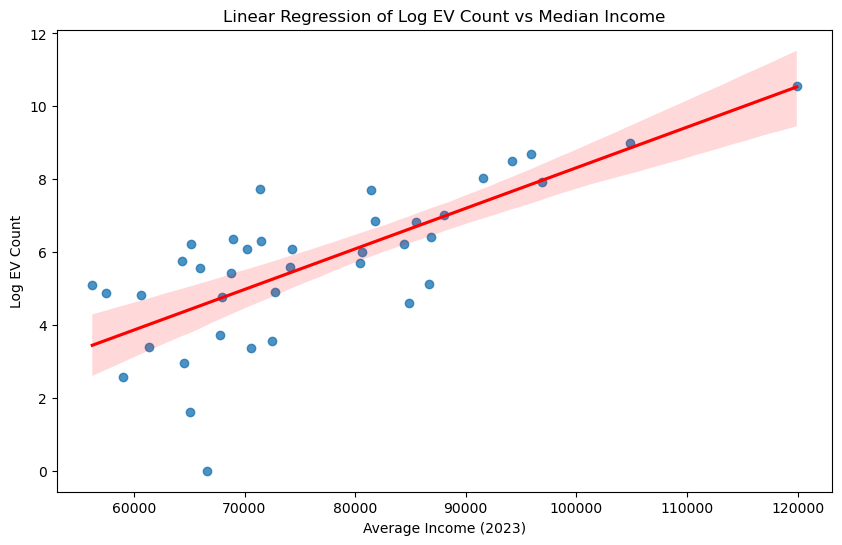

In [18]:
# Plot the regression
plt.figure(figsize=(10, 6))
sns.regplot(x=filtered_df["Average Income"], y=filtered_df["Log EV Count"], line_kws={"color": "red"})
plt.title("Linear Regression of Log EV Count vs Median Income")
plt.xlabel("Average Income (2023)")
plt.ylabel("Log EV Count")
plt.show()

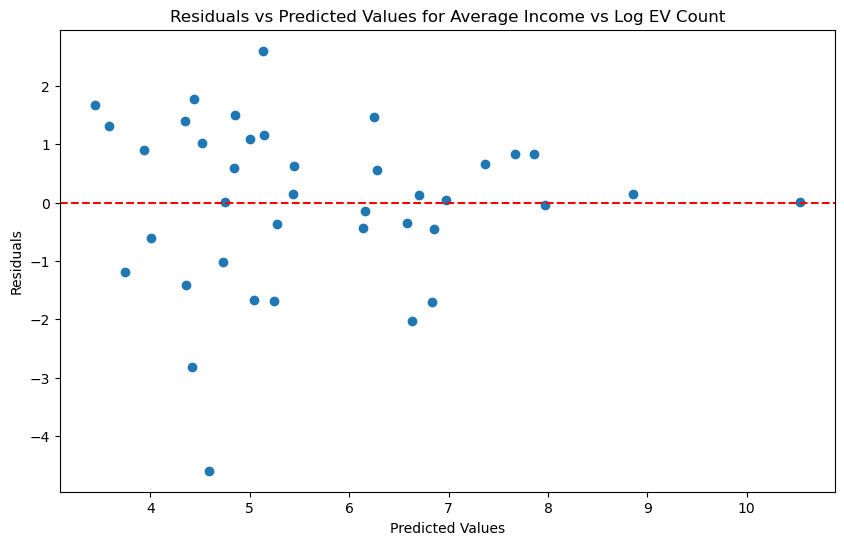

In [14]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values for Average Income vs Log EV Count') 
plt.show()

## Multivariate Regression
Can we better predict the total number of EV registrations in a county using multiple predictors, including BEV Proportion, Average Model Year, and Average Electric Range?
(based on feedback from TA)

### Overall Model Hypothesis

Null Hypothesis ($H_0$): The model with predictors (BEV Proportion, Average Model Year, Average Electric Range) does not significantly explain variation in the total EV registrations. 

Alternative Hypothesis ($H_A$): The model with predictors (BEV Proportion, Average Model Year, Average Electric Range) significantly explains variation in the total EV registrations.

In [15]:
# Define the predictors (independent variables)
X = aggregated_df[["BEV Proportion", "Average Model Year", "Average Electric Range"]]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Define the target (dependent variable)
y = aggregated_df["Total EV Count"]

# Fit the multivariate regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Total EV Count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2984
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.826
Time:                        13:27:23   Log-Likelihood:                -1406.6
No. Observations:                 148   AIC:                             2821.
Df Residuals:                     144   BIC:                             2833.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -1.0

### Interpretation
R-squared value = 0.142:
Approximately 14.2% of the variation in total EV registrations is explained by the predictors in the model. While this indicates some predictive power, the model has room for improvement, suggesting additional factors may contribute to EV registration trends.
The 95% confidence interval for the Average Income coefficient is [0.187, 0.406]. This interval does not include 0, which confirms the statistical significance of the result.

P-value for Average Income (<0.001):
The p-value is less than the commonly used significance threshold (e.g., 0.05). This allows us to reject the null hypothesis. There is strong evidence to suggest a statistically significant relationship between median income and total EV count.



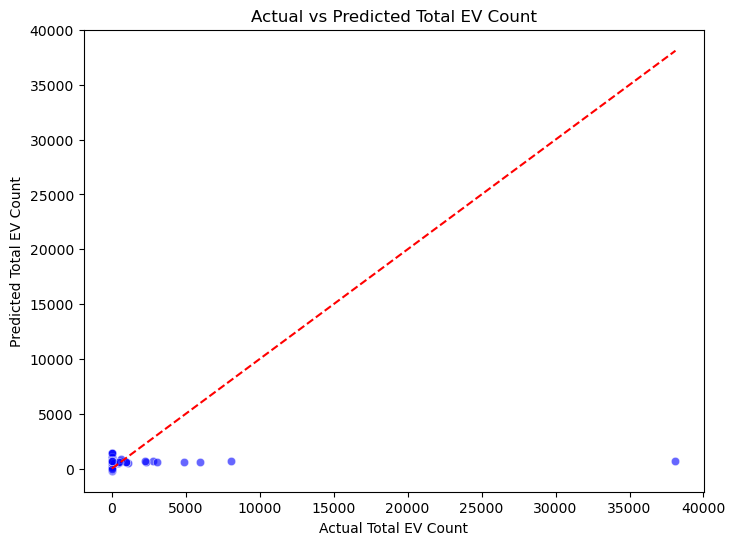

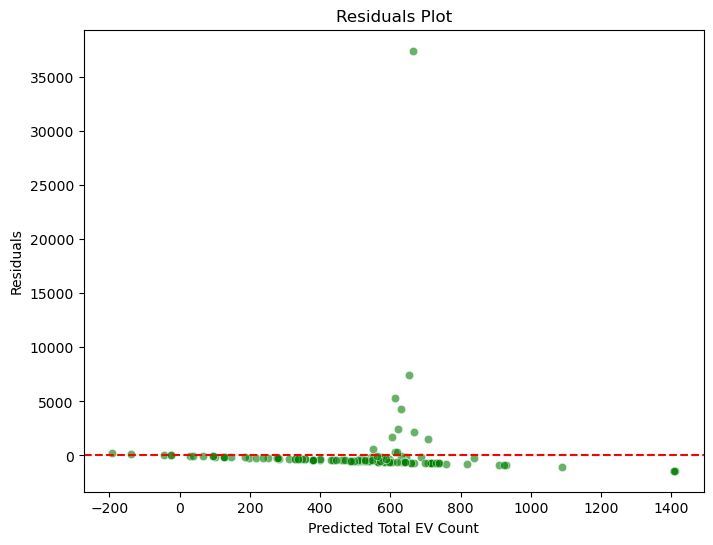

In [16]:
# Generate the predictions (fitted values)
aggregated_df['Predicted EV Count'] = model.predict(X)

# Plot the actual vs predicted EV count
plt.figure(figsize=(8, 6))
sns.scatterplot(x=aggregated_df['Total EV Count'], y=aggregated_df['Predicted EV Count'], color='blue', alpha=0.6)
plt.plot([aggregated_df['Total EV Count'].min(), aggregated_df['Total EV Count'].max()],
         [aggregated_df['Total EV Count'].min(), aggregated_df['Total EV Count'].max()],
         color='red', linestyle='--')  # Line of perfect prediction
plt.title('Actual vs Predicted Total EV Count')
plt.xlabel('Actual Total EV Count')
plt.ylabel('Predicted Total EV Count')
plt.show()

# Residuals Plot
aggregated_df['Residuals'] = aggregated_df['Total EV Count'] - aggregated_df['Predicted EV Count']
plt.figure(figsize=(8, 6))
sns.scatterplot(x=aggregated_df['Predicted EV Count'], y=aggregated_df['Residuals'], color='green', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Total EV Count')
plt.ylabel('Residuals')
plt.show()

## Summary of Results
The regression analysis for Pre-Registration 1 suggests that there is no significant relationship between the proportion of BEVs and the total EV registrations in a county. The p-value for the BEV Proportion coefficient (0.631) is too large to reject the null hypothesis, and the very low R-squared value indicates that BEV Proportion explains almost none of the variation in Total EV Count. Therefore, we conclude that BEV density is not a strong standalone predictor of overall EV registrations.
  
The regression analysis for Pre-Registration 2 demonstrates a significant positive relationship between median income and EV registrations. Counties with higher median incomes tend to register more EVs. The R-squared value indicates that median income accounts for a substantial proportion of the variation in EV registrations, although other factors likely contribute as well. This finding supports the hypothesis and suggests that income is an important factor influencing EV adoption trends.

In summary, while BEV density was not a significant factor, median income appears to play a crucial role in EV registrations. These findings can inform policies and incentives targeted at increasing EV adoption, especially in lower-income counties.

## Limitations
The regression model predicts fractional EV registrations, which is not realistic since registrations are discrete values.  
Counties with small populations or unique geographic conditions may skew the results. For example, a county with high BEV density but low total EV registrations due to a small population could distort the perceived relationship.  
The data represents a section in time, making it difficult to assess trends or causality. EV adoption patterns may evolve with new policies, technological advancements, or economic changes.

## Acknowledgements and Bibliography
Tools and Libraries: Python libraries including pandas, numpy, matplotlib, seaborn, statsmodels, and scikit-learn were used for data analysis and visualization.

Data Sources: The electric vehicle registration data was sourced from the Washington State Department of Licensing (DOL). Socioeconomic data was incorporated from publicly available datasets on county incomes and populations.

